# Research Wiki Analysis

We relied on a DokuWiki instance to organize this doctoral work, including:

- Literature
- Experiments
- Collections

Now that this PhD journey is close to being finished, we decided to analyze the content of this DokuWiki. This notebook represents such an attempt. We also extended this analysis to the BibTeX file included in the dissertation.

## Setup

In [4]:
if (!require("pacman")) install.packages("pacman")

pacman::p_load(
    tidyverse,
    rvest,
    bibtex,
    urltools,
    stringdist,
    SPARQL,
    tm,
    slam,
    textstem,
    RWeka
)

Loading required package: pacman



In [10]:
data_dir <- "data/"
output_dir <- "output/"

wiki_url <- "http://localhost/doku.php"
bibtex_fn <- "bibliography.bib"

bibtex_author_ignore <- "José Devezas"

# NOTE: You must create a tab-separated file with username and password for your wiki.
wiki_credentials_fn <- "/tmp/wiki_credentials"

# Either "wiki" or "bibtex"
data_source <- "wiki"

In [11]:
if (!file.exists(wiki_credentials_fn)) warning(sprintf("%s: not found", wiki_credentials_fn))

In [42]:
set_size <- function(width = 6, height = 4) options(repr.plot.width = width, repr.plot.height = height)
set_size()

In [27]:
login <- function(auth_path) {
    if (!file.exists(auth_path)) {
        stop(sprintf("%s must exist with a tab-separated user and pass", auth_path))
    }

    login_url <- sprintf("%s?id=start&do=login", wiki_url)
    auth <- read.table(auth_path, header = FALSE)
    names(auth) <- c("user", "pass")
    
    session <- html_session(login_url)
    login_form <- html_form(session)[[3]]  #in this case the submit is the 2nd form
    filled_form <- set_values(login_form, u=auth$user, p=auth$pass)
    submit_form(session, filled_form)
    session
}
session <- login(wiki_credentials_fn)

Submitting with '<unnamed>'



## Literature

### Data collection

First, let's scrape web data and build a CSV file with the following columns:
- title
- author
- year
- conference
- core
- journal
- scimago_h_index
- institution
- publisher
- review

We use the CORE CSV file exported from an [empty search of conferences using CORE 2018](http://portal.core.edu.au/conf-ranks/?search=&by=all&source=CORE2018&sort=atitle&page=1) to attempt to match our conference names with their naming scheme through the Jaccard index, using `stringdist`'s `amatch` function. We repeat this attempt based on the Scimago journal ranking data for an [empty search of journals in 2018](https://www.scimagojr.com/journalrank.php?type=j).

In [28]:
core <- read_csv(
    file.path(data_dir, "core_2018-20200211T0939.csv"),
    col_names = c(
        "id", "title", "acronym", "source", "rank", "has_data",
        "primary_for", "comments", "avg_rating"),
    col_types = cols())

head(core)

id   title                                                                 
1 2174 Asian Conference on Machine Learning\n                                
2 2173 Information Retrieval Facility Conference                             
3 2172 International Conference on Advanced Communications and Computation   
4 2189 International Conference on Ambient Systems, Networks and Technologies
5    4 3-D Digital Imaging and Modelling                                     
6    5 A Satellite workshop on Formal Approaches to Testing of Software      
  acronym  source   rank     has_data primary_for comments avg_rating
1 ACML     CORE2018 Unranked No       0801        NA       NA        
2 IRFC     CORE2018 Unranked Yes      0806        NA       NA        
3 INFOCOMP CORE2018 Unranked Yes      0805        NA       NA        
4 ANT      CORE2018 Unranked Yes      0802        0806     1005      
5 3DIM     CORE2018 C        No       0801        NA       NA        
6 FATES    CORE2018 C        No       0802        NA       NA

In [29]:
scimago <- read_delim(
    gzfile(file.path(data_dir, "scimagojr_2018-20200211T1402.csv.gz")),
    skip = 1,
    col_names = c(
        'rank', 'source_id', 'title', 'type', 'issn', 'sjr',
        'sjr_best_quartile', 'h_index', 'total_docs_2018',
        'total_docs_3_years', 'total_refs', 'total_cites_3_years',
        'citable_docs_3_years', 'cites_doc_2_years', 'ref_doc',
        'country', 'publisher', 'coverage', 'categories'),
    col_types = cols(),
    locale = locale(decimal_mark = ",", grouping_mark = "."),
    delim = ";")

head(scimago)

rank source_id  
1 1          28773
2 2          19434
3 3    21100812243
4 4          29431
5 5          18991
6 6          20315
  title                                                                                                                               
1 CA - A Cancer Journal for Clinicians                                                                                                
2 MMWR. Recommendations and reports : Morbidity and mortality weekly report. Recommendations and reports / Centers for Disease Control
3 Nature Reviews Materials                                                                                                            
4 Quarterly Journal of Economics                                                                                                      
5 Nature Reviews Genetics                                                                                                             
6 Nature Reviews Molecular Cell Biology                                                                                               
  type    issn               sjr    sjr_best_quartile h_index total_docs_2018
1 journal 15424863, 00079235 72.576 Q1                144      45            
2 journal 10575987, 15458601 48.894 Q1                134       3            
3 journal 20588437           34.171 Q1                 61      99            
4 journal 00335533, 15314650 30.490 Q1                228      40            
5 journal 14710056, 14710064 30.428 Q1                320     110            
6 journal 14710072, 14710080 30.397 Q1                386     119            
  total_docs_3_years total_refs total_cites_3_years citable_docs_3_years
1 127                3078       20088               103                 
2  12                 559        1043                12                 
3 195                8124        7297               104                 
4 124                2498        1495               120                 
5 387                7954        6395               153                 
6 391                9221        7208               197                 
  cites_doc_2_years ref_doc country       
1 206.85             68.40  United States 
2  86.00            186.33  United States 
3  70.16             82.06  United Kingdom
4  12.81             62.45  United Kingdom
5  43.13             72.31  United Kingdom
6  38.42             77.49  United Kingdom
  publisher                                        coverage               
1 Wiley-Blackwell                                  1950-ongoing           
2 Centers for Disease Control and Prevention (CDC) 1990-ongoing           
3 Nature Publishing Group                          2016-ongoing           
4 Oxford University Press                          1973-1974, 1976-ongoing
5 Nature Publishing Group                          2000-ongoing           
6 Nature Publishing Group                          2000-ongoing           
  categories                                                                                                                                                  
1 Hematology (Q1); Oncology (Q1)                                                                                                                              
2 Epidemiology (Q1); Health Information Management (Q1); Health (social science) (Q1); Health, Toxicology and Mutagenesis (Q1); Medicine (miscellaneous) (Q1) 
3 Biomaterials (Q1); Electronic, Optical and Magnetic Materials (Q1); Energy (miscellaneous) (Q1); Materials Chemistry (Q1); Surfaces, Coatings and Films (Q1)
4 Economics and Econometrics (Q1)                                                                                                                             
5 Genetics (Q1); Genetics (clinical) (Q1); Molecular Biology (Q1)                                                                                             
6 Cell Biology (Q1); Molecular Biology (Q1)

In [30]:
find_collection_rank <- function(collection, ranking, name_col = "title", ranking_col = "rank", max_dist=0.09) {
    if (!'data.frame' %in% class(ranking)) return(NA)
        
    idx <- amatch(
        collection, ranking[[name_col]], nomatch = "",
        matchNA = FALSE, maxDist = max_dist, method = "jaccard")
    
    rank <- ranking %>%
        slice(idx) %>%
        select(!!sym(ranking_col)) %>%
        pull()
    
    if (length(rank) < 1) NA else rank
}

In [31]:
get_literature_data_from_wiki <- function(csv_path) {
    get_metadata_value <- function(metadata_table, col_name) {
        value <- metadata_table %>%
            html_nodes(xpath=sprintf('(.//th[normalize-space(text()) = "%s"]/following::td)[1]/a', col_name)) %>%
            html_text() %>%
            str_trim() %>%
            paste(collapse = "|")
        
        if (length(value) < 1) NA else value
    }
    
    bib_url <- param_set(wiki_url, "id", "phd:bibliography")
    
    following_xpath <- '//div[contains(@class, "page")]//h2[text() = "General"]'
    links <- session %>%
        jump_to(bib_url) %>%
        html_nodes(xpath=sprintf('%s/following::a[contains(@class, "wikilink1")]', following_xpath)) %>%
        html_attr("href")
    
    data <- lapply(links, function(link) {
        article_url <- bib_url
        parameters(article_url) <- NULL
        path(article_url) <- link
        
        page <- session %>%
            jump_to(article_url) %>%
            html_nodes(xpath='//div[contains(@class, "page")]')
        
        title <- page %>%
            html_nodes(xpath='.//h1') %>%
            html_text()

        metadata_table <- page %>%
            html_nodes(xpath='(.//table)[1]')
        
        authors <- get_metadata_value(metadata_table, "Authors")
        year <- get_metadata_value(metadata_table, "Year")
        conference <- get_metadata_value(metadata_table, "Conference")
        core <- find_collection_rank(conference, core)
        journal <- get_metadata_value(metadata_table, "Journal")
        scimago_h_index <- find_collection_rank(journal, scimago, ranking_col = "h_index", max_dist=0.1)
        scimago_sjr <- find_collection_rank(journal, scimago, ranking_col = "sjr", max_dist=0.1)
        scimago_quartile <- find_collection_rank(
            journal, scimago, ranking_col = "sjr_best_quartile", max_dist=0.1)
        institution <- get_metadata_value(metadata_table, "Institution")
        #inst_country <- find_institution_country(institution)
        publisher <- get_metadata_value(metadata_table, "Publisher")
        
        p_or_div_xpath <- './/*[@class = "dw__toc"]/following::*[name() = "p" or name() = "div"]'
        exclusion_xpath <- '[not(descendant::table) and not(descendant::button)]'
        
        review <- page %>%
            html_nodes(xpath=sprintf("%s%s", p_or_div_xpath, exclusion_xpath)) %>%
            html_text() %>%
            str_trim() %>%
            unique() %>%
            paste(collapse = "\n")
        
        tibble(
            url=article_url,
            title=title,
            authors=authors,
            year=year,
            conference=conference,
            core=core,
            journal=journal,
            scimago_h_index=scimago_h_index,
            scimago_sjr=scimago_sjr,
            scimago_quartile=scimago_quartile,
            institution=institution,
            #inst_country=inst_country,
            publisher=publisher,
            review=review
        ) %>%
            mutate_at(vars(year), function(x) suppressWarnings(as.integer(x)))
    }) %>%
        bind_rows() %>%
        mutate(core=ordered(core, levels=c("C", "B", "A", "A*")),
               scimago_quartile=as_factor(scimago_quartile))
    
    write_csv(data, csv_path)
    
    data
}

In [32]:
booktitle_to_conference <- function(booktitle) {
    conference <- str_match(booktitle, "(?:Proceedings of the \\d+(?:th|st|nd|rd) )?([^,.]+)")[2]
    conference <- gsub("Advances in Information Retrieval - \\d+(?:th|st|nd|rd)", "", conference)
    conference <- gsub("[\\{}]+", "", conference)
    conference <- gsub("\\(.*?\\)", "", conference)
    conference <- gsub("\\d+", "", conference)
    conference <- gsub("Annual", "", conference, ignore.case = TRUE)
    str_trim(conference)
}

In [33]:
get_literature_data_from_bibtex <- function(csv_path) {
    bib <- suppressMessages(read.bib(file.path(data_dir, bibtex_fn)))
    
    data <- lapply(bib, function(pub) {
        conference <- booktitle_to_conference(pub$booktitle)
        normalized_conference <- find_collection_rank(conference, core, ranking_col = "title")
        if (!is.na(normalized_conference)) conference <- normalized_conference

        core <- find_collection_rank(conference, core)
        
        scimago_h_index <- find_collection_rank(pub$journal, scimago, ranking_col = "h_index")
        scimago_sjr <- find_collection_rank(pub$journal, scimago, ranking_col = "sjr")
        scimago_quartile <- find_collection_rank(pub$journal, scimago, ranking_col = "sjr_best_quartile")

        tibble(
            url=ifelse(is.null(pub$url), NA, pub$url),
            title= gsub("[\\{}]+", "", pub$title),
            authors=paste(pub$author, collapse = "|"),
            year=pub$year,
            conference=conference,
            core=core,
            journal=ifelse(is.null(pub$journal), NA, gsub("[\\{}]+", "", pub$journal)),
            scimago_h_index=scimago_h_index,
            scimago_sjr=scimago_sjr,
            scimago_quartile=scimago_quartile,
            institution=ifelse(is.null(pub$institution), NA,  gsub("[\\{}]+", "", pub$institution)),
            #inst_country=inst_country,
            publisher=ifelse(is.null(pub$publisher), NA,  gsub("[\\{}]+", "", pub$publisher)),
            review=NA
        ) %>%
            mutate_at(vars(year), function(x) suppressWarnings(as.integer(x)))
    }) %>%
        bind_rows() %>%
        mutate(core=ordered(core, levels=c("C", "B", "A", "A*")),
               scimago_quartile=as_factor(scimago_quartile)) %>%
        filter(!grepl(bibtex_author_ignore, authors))
    
    write_csv(data, csv_path)
    
    data
}

In [34]:
get_literature_data <- function(csv_path, from="wiki") {
    stopifnot(from %in% c("wiki", "bibtex"))
    
    if (from == "wiki") {
        get_literature_data_from_wiki(csv_path)
    } else {
        get_literature_data_from_bibtex(csv_path)
    }
}

pub <- get_literature_data(file.path(output_dir, sprintf("%s-literature.csv", data_source)), data_source); pub

url                                                                                                                                         
1   http://localhost/doku.php?id=phd:bibliography:writing-for-computer-science                                                                  
2   http://localhost/doku.php?id=phd:bibliography:an-example-based-mapping-method-for-text-categorization-and-retrieval                         
3   http://localhost/doku.php?id=phd:bibliography:semantic-web-topic-models-integrating-ontological-knowledge-and-probabilistic-topic-models    
4   http://localhost/doku.php?id=phd:bibliography:deep-joint-entity-disambiguation-with-local-neural-attention                                  
5   http://localhost/doku.php?id=phd:bibliography:open-information-extraction-from-the-web                                                      
6   http://localhost/doku.php?id=phd:bibliography:knowledge-vault-a-web-scale-approach-to-probabilistic-knowledge-fusion                        
7   http://localhost/doku.php?id=phd:bibliography:entity-linking-with-a-knowledge-base-issues-techniques-and-solutions                          
8   http://localhost/doku.php?id=phd:bibliography:high-throughput-and-language-agnostic-entity-disambiguation-and-linking-on-user-generated-data
9   http://localhost/doku.php?id=phd:bibliography:entity-linking-for-tweets                                                                     
10  http://localhost/doku.php?id=phd:bibliography:entity-linking-for-queries-by-searching-wikipedia-sentences                                   
11  http://localhost/doku.php?id=phd:bibliography:exploiting-entity-linking-in-queries-for-entity-retrieval                                     
12  http://localhost/doku.php?id=phd:bibliography:entity-linking-meets-word-sense-disambiguation-a-unified-approach                             
13  http://localhost/doku.php?id=phd:bibliography:semantic-data-integration-for-knowledge-graph-construction-at-query-time                      
14  http://localhost/doku.php?id=phd:bibliography:deeppath-a-reinforcement-learning-method-for-knowledge-graph-reasoning                        
15  http://localhost/doku.php?id=phd:bibliography:classification-of-graph-metrics                                                               
16  http://localhost/doku.php?id=phd:bibliography:on-multidimensional-network-measures                                                          
17  http://localhost/doku.php?id=phd:bibliography:struc2vec-learning-node-representations-from-structural-identity                              
18  http://localhost/doku.php?id=phd:bibliography:injecting-semantic-background-knowledge-into-neural-networks-using-graph-embeddings           
19  http://localhost/doku.php?id=phd:bibliography:graph-theory-with-applications                                                                
20  http://localhost/doku.php?id=phd:bibliography:graph-theory-with-applications                                                                
21  http://localhost/doku.php?id=phd:bibliography:scalable-graph-processing-frameworks-a-taxonomy-and-open-challenges                           
22  http://localhost/doku.php?id=phd:bibliography:hits-on-the-web-how-does-it-compare                                                           
23  http://localhost/doku.php?id=phd:bibliography:what-makes-a-link-successful-on-wikipedia                                                     
24  http://localhost/doku.php?id=phd:bibliography:the-pagerank-citation-ranking-bringing-order-to-the-web                                       
25  http://localhost/doku.php?id=phd:bibliography:multilinear-pagerank                                                                          
26  http://localhost/doku.php?id=phd:bibliography:dirichlet-pagerank                                                                            
27  http://localhost/doku.php?id=phd:bibliography:monte-carlo-methods-in-pagerank-computa

### Global statistics

In [36]:
pub_stats <- tibble(
    num_pubs=nrow(pub),
    num_authors=length(unique(unlist(str_split(pub$authors, "\\|") %>% lapply(str_trim)))),
    min_year=min(pub$year, na.rm = TRUE),
    max_year=max(pub$year, na.rm = TRUE),
    num_conferences=length(unique(na.omit(pub$conference))),
    min_core=min(pub$core, na.rm = TRUE),
    max_core=max(pub$core, na.rm = TRUE),
    num_journals=length(unique(na.omit(pub$journal))),
    min_scimago_hindex=min(pub$scimago_h_index, na.rm = TRUE),
    max_scimago_hindex=max(pub$scimago_h_index, na.rm = TRUE),
    min_scimago_sjr=min(pub$scimago_sjr, na.rm = TRUE),
    max_scimago_sjr=max(pub$scimago_sjr, na.rm = TRUE),
    num_institutions=length(unique(na.omit(pub$institution))),
    num_publishers=length(unique(na.omit(pub$publisher))),
    num_reviews=pub %>% filter(review != '') %>% nrow()
) %>%
    mutate(authors_per_pub=num_authors / num_pubs) %>%
    select(num_pubs, num_authors, authors_per_pub, everything())

pub_stats

num_pubs num_authors authors_per_pub min_year max_year num_conferences
1 119      375         3.151261        1957     2019     30             
  min_core max_core num_journals min_scimago_hindex max_scimago_hindex
1 C        A*       30           12                 189               
  min_scimago_sjr max_scimago_sjr num_institutions num_publishers num_reviews
1 0.146           3.658           14               3              20

### Distribution of publications

#### Per year

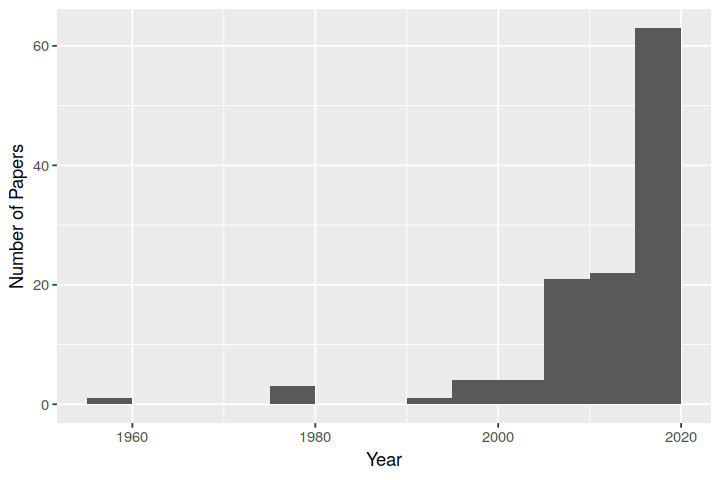

In [44]:
set_size()
ggplot(pub, aes(x=year)) +
    geom_histogram(binwidth = 5, boundary = 5) +
    labs(x="Year", y="Number of Papers")
ggsave(filename = sprintf("output/%s-publications_per_year.pdf", data_source),
       width = getOption("repr.plot.width"),
       height = getOption("repr.plot.height"))

#### Per conference ranking

We use the core rankings from 2018.

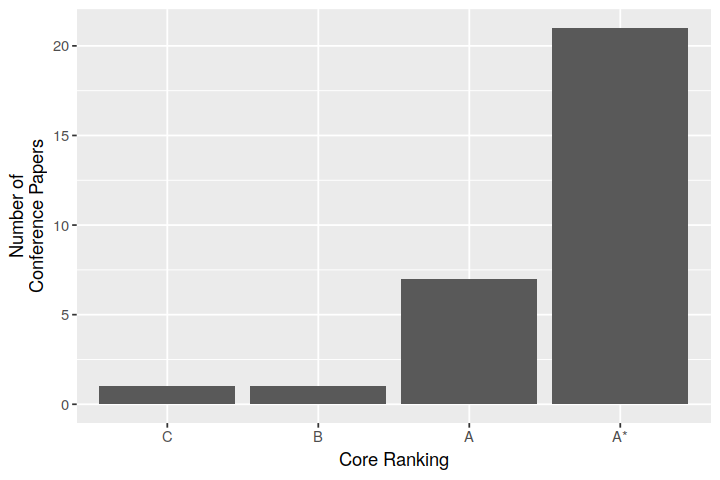

In [47]:
set_size()
ggplot(pub %>% filter(!is.na(core)), aes(x=core)) +
    stat_count() +
    labs(x="Core Ranking", y="Number of\nConference Papers")
ggsave(filename = sprintf("output/%s-publications_per_conference_ranking.pdf", data_source),
       width = getOption("repr.plot.width"),
       height = getOption("repr.plot.height"))

#### Per journal ranking

We use h-index as provided by Scimago data from 2018 for journal ranking.

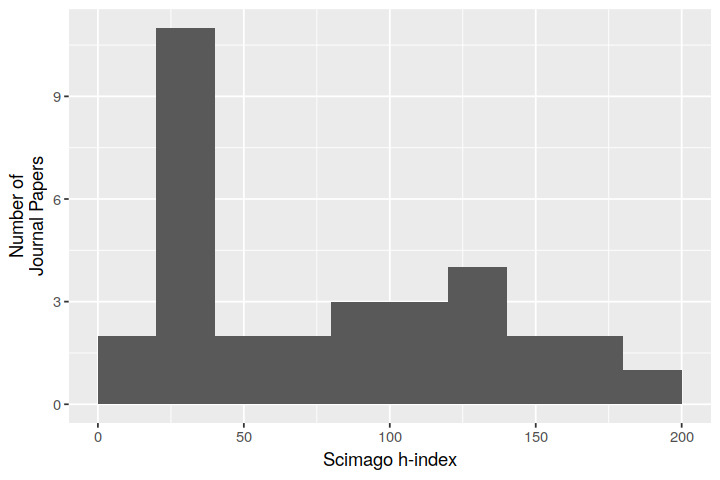

In [49]:
set_size()
ggplot(pub %>% filter(!is.na(scimago_h_index)), aes(x=scimago_h_index)) +
    geom_histogram(binwidth = 20, boundary = 20) +
    labs(x="Scimago h-index", y="Number of\nJournal Papers")
ggsave(filename = sprintf("output/%s-publications_per_journal_h_index.pdf", data_source),
       width = getOption("repr.plot.width"),
       height = getOption("repr.plot.height"))

In [50]:
pub %>%
    arrange(desc(scimago_h_index)) %>%
    select(journal, scimago_h_index) %>%
    unique() %>%
    head(20)

journal                                                          
1  Communications of the ACM                                        
2  IEEE Transactions on Neural Networks and Learning Systems        
3  Expert Systems With Applications                                 
4  IEEE Transactions on Knowledge and Data Engineering              
5  Transactions on Knowledge and Data Engineering                   
6  ACM Computing Surveys                                            
7  Journal of the Association for Information Science and Technology
8  Journal of the ACM                                               
9  SIAM Journal on Numerical Analysis                               
10 International Journal of Human-Computer Studies                  
11 Engineering Applications of Artificial Intelligence              
12 Computational Linguistics                                        
13 SIAM Journal on Matrix Analysis and Applications                 
14 ACM Transactions on Information Systems                          
15 Journal of Intelligent Information Systems                       
16 Journal of Documentation                                         
17 IEEE Access                                                      
18 Foundations and Trends® in Information Retrieval                 
19 Journal of Ambient Intelligence and Humanized Computing          
20 International Journal of Metadata, Semantics and Ontologies      
   scimago_h_index
1  189            
2  180            
3  162            
4  148            
5  148            
6  132            
7  124            
8  117            
9  109            
10 109            
11  86            
12  85            
13  83            
14  75            
15  72            
16  58            
17  56            
18  25            
19  23            
20  18

We also explore the quartiles, as provided by Scimago data from 2018 for journal ranking.

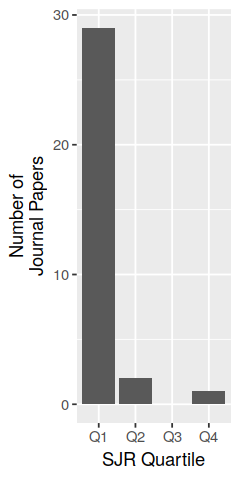

In [51]:
set_size(width=2)
quartile_levels <- c("Q1", "Q2", "Q3", "Q4")

ggplot(pub %>% filter(!is.na(scimago_quartile)),
       aes(x=(scimago_quartile %>% fct_expand(quartile_levels) %>% fct_relevel(quartile_levels)))) +
    geom_bar(stat = "count") +
    scale_x_discrete(drop=FALSE) +
    labs(x="SJR Quartile", y="Number of\nJournal Papers")
ggsave(filename = sprintf("output/%s-publications_per_journal_sjr_quartile.pdf", data_source),
       width = getOption("repr.plot.width"),
       height = getOption("repr.plot.height"))

In [52]:
pub %>%
    arrange(desc(scimago_sjr)) %>%
    select(journal, scimago_quartile) %>%
    unique() %>%
    head(20)

journal                                                               
1  IEEE Transactions on Neural Networks and Learning Systems             
2  SIAM Journal on Numerical Analysis                                    
3  Journal of the ACM                                                    
4  ACM Computing Surveys                                                 
5  Journal of the Association for Information Science and Technology     
6  Journal of Intelligent Information Systems                            
7  SIAM Journal on Matrix Analysis and Applications                      
8  Expert Systems With Applications                                      
9  IEEE Transactions on Knowledge and Data Engineering                   
10 Transactions on Knowledge and Data Engineering                        
11 Foundations and Trends® in Information Retrieval                      
12 Engineering Applications of Artificial Intelligence                   
13 Journal of Documentation                                              
14 Communications of the ACM                                             
15 International Journal of Human-Computer Studies                       
16 IEEE Access                                                           
17 ACM Transactions on Information Systems                               
18 Computational Linguistics                                             
19 International Conference on Implementation and Application of Automata
20 Journal of Ambient Intelligence and Humanized Computing               
   scimago_quartile
1  Q1              
2  Q1              
3  Q1              
4  Q1              
5  Q1              
6  Q1              
7  Q1              
8  Q1              
9  Q1              
10 Q1              
11 Q1              
12 Q1              
13 Q1              
14 Q1              
15 Q1              
16 Q1              
17 Q1              
18 Q1              
19 Q2              
20 Q2

### Number of papers

In [63]:
top_n_field <- function(field, n = 10) {
    pub %>%
        select(!!field) %>%
        mutate(!!field := str_split(!!sym(field), "\\|")) %>%
        unnest(cols=!!field) %>%
        filter(!!sym(field) != "") %>%
        count(!!sym(field)) %>%
        arrange(desc(n)) %>%
        head(n)
}

top_n_field("authors")
top_n_field("year")

authors           n
1  Krisztian Balog   4
2  Chenyan Xiong     3
3  Jamie Callan      3
4  Justin Zobel      3
5  Laura Dietz       3
6  Michael Bendersky 3
7  W. Bruce Croft    3
8  Alistair Moffat   2
9  ChengXiang Zhai   2
10 Christina Lioma   2

year n 
1  2017 35
2  2016 14
3  2018 10
4  2009  7
5  2015  7
6  2007  5
7  2014  5
8  2008  4
9  2012  4
10 2019  4

#### For top 10 authors

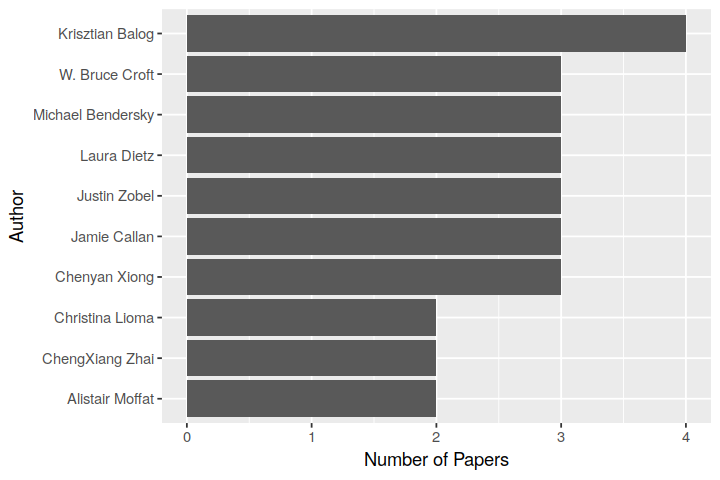

In [65]:
set_size()

ggplot(top_n_field("authors"), aes(x=reorder(authors, n), y=n)) +
    geom_bar(stat="identity") +
    labs(x="Author", y="Number of Papers") +
    coord_flip()
ggsave(filename = sprintf("output/%s-publications_per_author-top_10.pdf", data_source),
       width = getOption("repr.plot.width"),
       height = getOption("repr.plot.height"))

#### For top 10 years

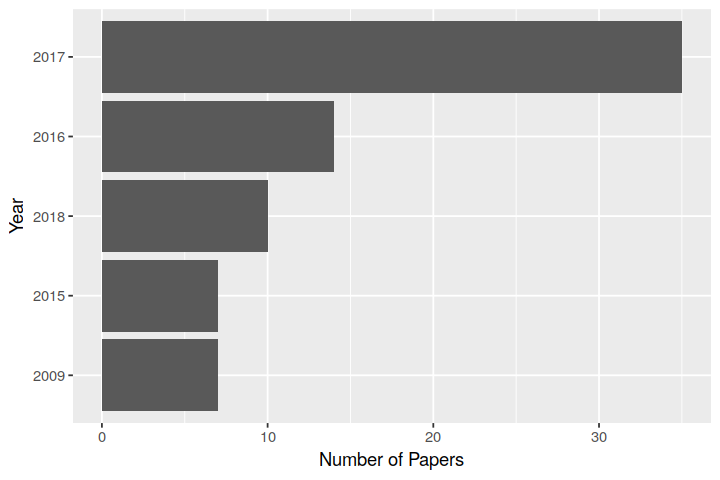

In [67]:
set_size()

ggplot(top_n_field("year", 5), aes(x=reorder(year, n), y=n)) +
    geom_bar(stat="identity") +
    labs(x="Year", y="Number of Papers") +
    coord_flip()
ggsave(filename = sprintf("output/%s-publications_per_year-top_10.pdf", data_source),
       width = getOption("repr.plot.width"),
       height = getOption("repr.plot.height"))

#### For top 10 conferences

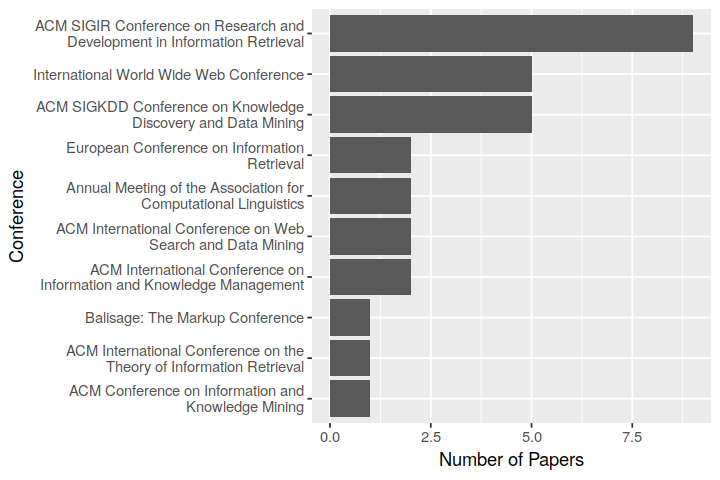

In [69]:
set_size()

ggplot(top_n_field("conference"), aes(x=reorder(str_wrap(conference, 40), n), y=n)) +
    geom_bar(stat="identity") +
    labs(x="Conference", y="Number of Papers") +
    coord_flip()
ggsave(filename = sprintf("output/%s-publications_per_conference-top_10.pdf", data_source),
       width = getOption("repr.plot.width"),
       height = getOption("repr.plot.height"))

#### For top 10 journals

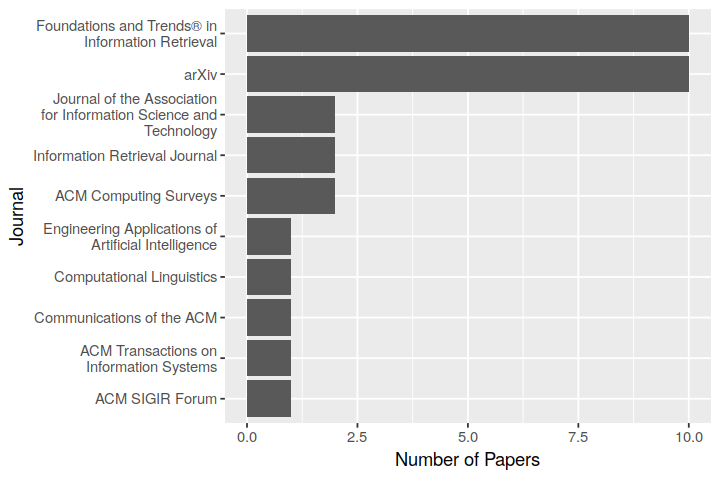

In [70]:
if (data_source == "wiki") {
    wrap_width <- 30
} else {
    wrap_width <- 35
}

ggplot(top_n_field("journal"), aes(x=reorder(str_wrap(journal, wrap_width), n), y=n)) +
    geom_bar(stat="identity") +
    labs(x="Journal", y="Number of Papers") +
    coord_flip()
ggsave(filename = sprintf("output/%s-publications_per_journal-top_10.pdf", data_source),
       width = getOption("repr.plot.width"),
       height = getOption("repr.plot.height"))

#### For top 10 institutions

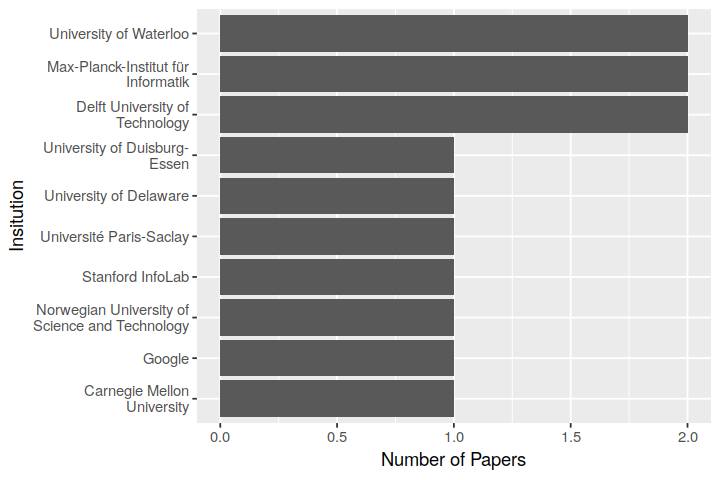

In [72]:
set_size()

ggplot(top_n_field("institution"), aes(x=reorder(str_wrap(institution, 23), n), y=n)) +
    geom_bar(stat="identity") +
    labs(x="Insitution", y="Number of Papers") +
    coord_flip()
ggsave(filename = sprintf("output/%s-publications_per_institution-top_10.pdf", data_source),
       width = getOption("repr.plot.width"),
       height = getOption("repr.plot.height"))

#### For top 10 publishers

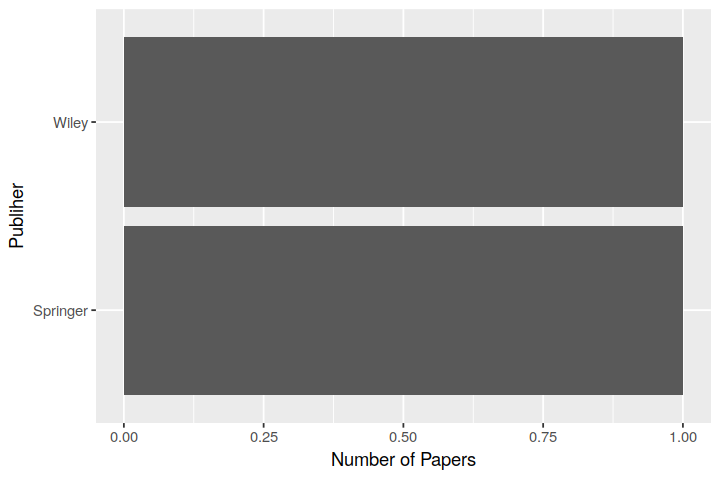

In [73]:
set_size()

ggplot(top_n_field("publisher"), aes(x=reorder(str_wrap(publisher, 25), n), y=n)) +
    geom_bar(stat="identity") +
    labs(x="Publiher", y="Number of Papers") +
    coord_flip()
ggsave(filename = sprintf("output/%s-publications_per_publisher-top_10.pdf", data_source),
       width = getOption("repr.plot.width"),
       height = getOption("repr.plot.height"))

### Most frequent words

In [74]:
get_tf_tops <- function(text, n = 10) {
    n_gram_tokenizer <- function(x) NGramTokenizer(x, Weka_control(min = 1, max = 2))
    #lemmatize <- function(x) tm_map(x, content_transformer(lemmatize_strings))

    VCorpus(VectorSource(text)) %>%
        #lemmatize() %>%
        tm_map(removeWords, stopwords("english")) %>%
        TermDocumentMatrix(control = list(
            tokenize = n_gram_tokenizer,
            removePunctuation = TRUE,
            removeNumbers = TRUE,
            weighting = weightTf,
            stopwords = TRUE
        )) %>%
        row_sums() %>%
        enframe() %>%
        arrange(desc(value)) %>%
        head(n)
}

#### In publication titles

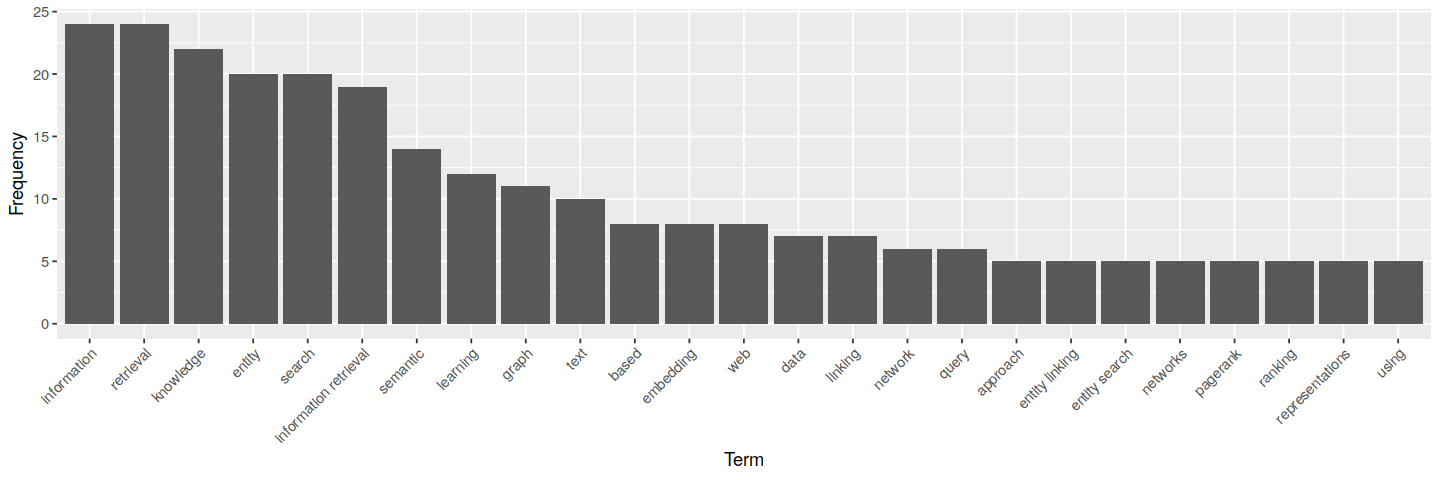

In [76]:
set_size(width=12)

get_tf_tops(pub$title, 25) %>%
    ggplot(aes(x=reorder(name, -value), y=value)) +
        geom_bar(stat="identity") +
        labs(x="Term", y="Frequency") +
        theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust=1))
ggsave(filename = sprintf("output/%s-top_10_n_grams_per_publication_title.pdf", data_source),
       width = getOption("repr.plot.width"),
       height = getOption("repr.plot.height"))

#### In literature review

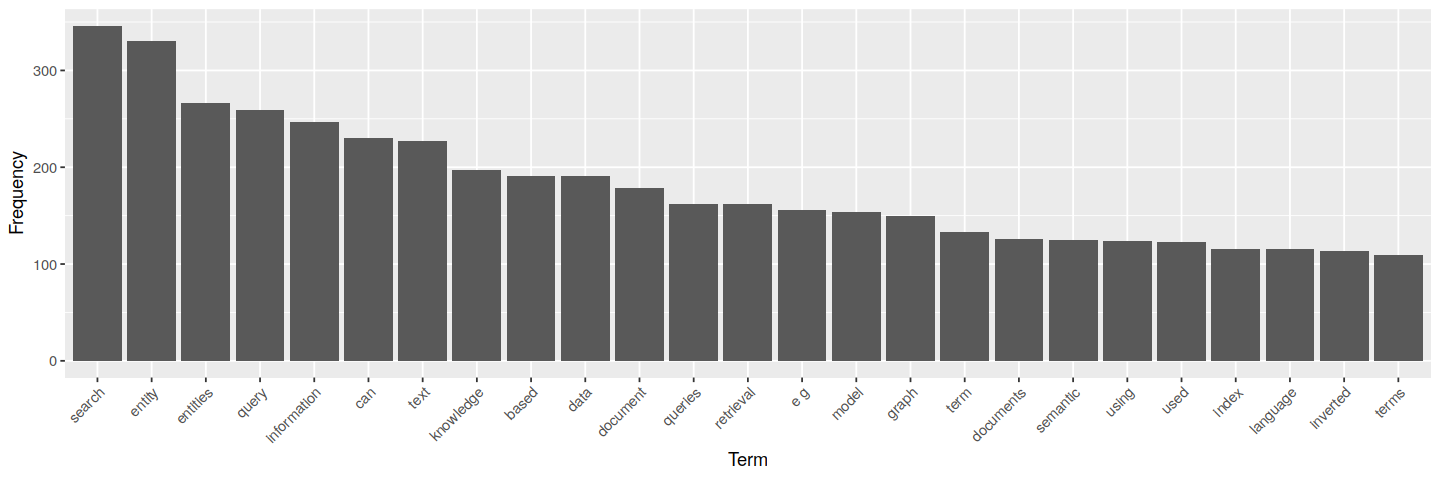

In [77]:
if (data_source == "wiki") {
    set_size(width = 12)

    p <- get_tf_tops(pub$review, 25) %>%
        ggplot(aes(x=reorder(name, -value), y=value)) +
            geom_bar(stat="identity") +
            labs(x="Term", y="Frequency") +
            theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust=1))
    ggsave(plot = p, filename = sprintf("output/%s-top_10_n_grams_per_publication_review.pdf", data_source),
           width = getOption("repr.plot.width"),
           height = getOption("repr.plot.height"))
    p
}

### Revision history for phd:bibliography namespace

Run the following command in the directory of your DokuWiki instance to generate the required data for analysis (put it in the data directory of the notebook):

```
$ find data/meta/phd/bibliography -name "*.changes" | xargs cat > phd_bibliography-changes.tsv
```

In [79]:
load_wiki_changes <- function(path) {
    col_names <- c("timestamp", "ip", "type", "id", "user", "summary", "extra", "bytes")
    suppressWarnings({
        read_tsv(path, col_names = col_names, col_types = cols(timestamp = col_integer())) %>%
            mutate(
                type=factor(type, levels = c("D", "R", "e", "E", "C"),
                            labels = c("Delete", "Reverted", "Minor Edit", "Edit", "Create")),
                date=as.POSIXct(timestamp, origin = "1970-01-01")) %>%
            select(timestamp, date, everything())
    })
}

In [80]:
lit_changes <- load_wiki_changes(file.path(data_dir, "phd_bibliography-changes.tsv")); lit_changes

timestamp  date                ip             type      
1    1490707005 2017-03-28 14:16:45 172.30.29.172  Create    
2    1490707047 2017-03-28 14:17:27 172.30.29.172  Edit      
3    1524145457 2018-04-19 14:44:17 172.30.8.172   Create    
4    1501177095 2017-07-27 18:38:15 172.30.12.218  Create    
5    1501177126 2017-07-27 18:38:46 172.30.12.218  Edit      
6    1485207029 2017-01-23 21:30:29 94.132.179.153 Delete    
7    1479374132 2016-11-17 09:15:32 172.30.30.176  Create    
8    1479376593 2016-11-17 09:56:33 172.30.30.176  Edit      
9    1479376811 2016-11-17 10:00:11 172.30.30.176  Edit      
10   1479377733 2016-11-17 10:15:33 172.30.30.176  Edit      
11   1479920012 2016-11-23 16:53:32 172.30.30.176  Edit      
12   1481282472 2016-12-09 11:21:12 172.30.20.73   Minor Edit
13   1484748442 2017-01-18 14:07:22 172.30.20.1    Create    
14   1486056363 2017-02-02 17:26:03 172.30.20.1    Edit      
15   1486059145 2017-02-02 18:12:25 172.30.20.1    Minor Edit
16   1507798988 2017-10-12 10:03:08 172.30.12.218  Create    
17   1507811238 2017-10-12 13:27:18 172.30.12.218  Edit      
18   1507823407 2017-10-12 16:50:07 172.30.12.218  Edit      
19   1507823655 2017-10-12 16:54:15 172.30.12.218  Edit      
20   1507825113 2017-10-12 17:18:33 172.30.12.218  Edit      
21   1507826039 2017-10-12 17:33:59 172.30.12.218  Edit      
22   1507899190 2017-10-13 13:53:10 172.30.12.218  Edit      
23   1507902140 2017-10-13 14:42:20 172.30.12.218  Edit      
24   1507912822 2017-10-13 17:40:22 172.30.12.218  Edit      
25   1507913020 2017-10-13 17:43:40 172.30.12.218  Edit      
26   1507913026 2017-10-13 17:43:46 172.30.12.218  Minor Edit
27   1507913106 2017-10-13 17:45:06 172.30.12.218  Edit      
28   1490711262 2017-03-28 15:27:42 172.30.29.172  Create    
29   1490711290 2017-03-28 15:28:10 172.30.29.172  Edit      
30   1538041316 2018-09-27 10:41:56 10.227.107.163 Create    
⋮    ⋮          ⋮                   ⋮              ⋮         
1776 1505208307 2017-09-12 10:25:07 172.30.12.218  Edit      
1777 1505209006 2017-09-12 10:36:46 172.30.12.218  Edit      
1778 1505220868 2017-09-12 13:54:28 172.30.12.218  Edit      
1779 1505220886 2017-09-12 13:54:46 172.30.12.218  Edit      
1780 1505220897 2017-09-12 13:54:57 172.30.12.218  Edit      
1781 1505220903 2017-09-12 13:55:03 172.30.12.218  Edit      
1782 1505221228 2017-09-12 14:00:28 172.30.12.218  Edit      
1783 1505222109 2017-09-12 14:15:09 172.30.12.218  Edit      
1784 1505730388 2017-09-18 11:26:28 172.30.12.218  Edit      
1785 1484748442 2017-01-18 14:07:22 172.30.20.1    Delete    
1786 1574780704 2019-11-26 15:05:04 10.227.147.31  Create    
1787 1574781153 2019-11-26 15:12:33 10.227.147.31  Edit      
1788 1574781245 2019-11-26 15:14:05 10.227.147.31  Edit      
1789 1574846078 2019-11-27 09:14:38 10.227.147.31  Minor Edit
1790 1574846093 2019-11-27 09:14:53 10.227.147.31  Edit      
1791 1524142647 2018-04-19 13:57:27 172.30.8.172   Create    
1792 1494839122 2017-05-15 10:05:22 172.30.29.172  Create    
1793 1494839194 2017-05-15 10:06:34 172.30.29.172  Edit      
1794 1494840522 2017-05-15 10:28:42 172.30.29.172  Edit      
1795 1496050278 2017-05-29 10:31:18 172.30.15.184  Create    
1796 1484748828 2017-01-18 14:13:48 172.30.20.1    Delete    
1797 1488809815 2017-03-06 14:16:55 172.30.29.172  Create    
1798 1494839226 2017-05-15 10:07:06 172.30.29.172  Minor Edit
1799 1479374226 2016-11-17 09:17:06 172.30.30.176  Create    
1800 1479376602 2016-11-17 09:56:42 172.30.30.176  Delete    
1801 1550662566 2019-02-20 11:36:06 10.227.145.25  Create    
1802 1550846334 2019-02-22 14:38:54 10.227.145.25  Edit      
1803 1550846337 2019-02-22 14:38:57 10.227.145.25  Minor Edit
1804 1507811729 2017-10-12 13:35:29 172.30.12.218  Delete    
1805 1490806382 2017-03-29 17:53:02 172.30.29.172  Create    
     id                                                                                                                                       
1    phd:bibliogra

Warning message:
“Removed 14 rows containing missing values (geom_bar).”
Warning message:
“Removed 14 rows containing missing values (geom_bar).”


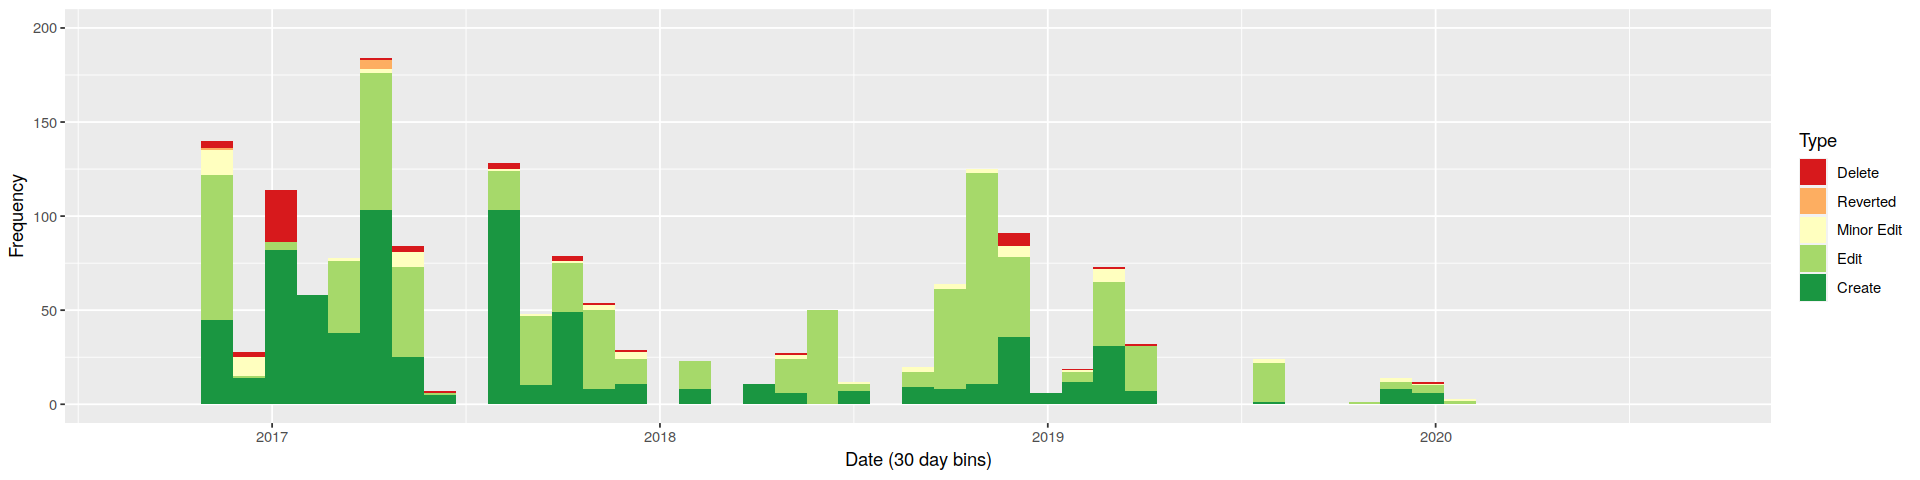

In [82]:
set_size(width=16)

lit_changes %>%
    ggplot(aes(x=as.Date(date), fill=type)) +
        geom_histogram(binwidth = 30, boundary = 30) +
        scale_fill_brewer("Type", type = "div", palette = 8) +
        xlim(as.Date("2016-09-01"), as.Date("2020-08-31")) +
        ylim(0, 200) +
        labs(x="Date (30 day bins)", y="Frequency")
ggsave(filename = "output/wiki_changes-phd_bibliography.pdf",
       width = getOption("repr.plot.width"),
       height = getOption("repr.plot.height"))

## Collections

### Revision history for phd:collections namespace

Run the following command in the directory of your DokuWiki instance to generate the required data for analysis (put it in the data directory of the notebook):

```
$ find data/meta/phd/collections -name "*.changes" | xargs cat > phd_collections-changes.tsv
```

In [83]:
col_changes <- load_wiki_changes(file.path(data_dir, "phd_collections-changes.tsv")); col_changes

timestamp  date                ip             type      
1   1511875923 2017-11-28 13:32:03 172.30.7.198   Delete    
2   1511875867 2017-11-28 13:31:07 172.30.7.198   Delete    
3   1549961747 2019-02-12 08:55:47 10.227.145.25  Create    
4   1549962034 2019-02-12 09:00:34 10.227.145.25  Edit      
5   1549962157 2019-02-12 09:02:37 10.227.145.25  Edit      
6   1551200382 2019-02-26 16:59:42 10.227.145.25  Edit      
7   1552057478 2019-03-08 15:04:38 10.227.145.25  Edit      
8   1569932390 2019-10-01 13:19:50 10.227.153.97  Edit      
9   1519738866 2018-02-27 13:41:06 172.30.24.43   Create    
10  1519738880 2018-02-27 13:41:20 172.30.24.43   Edit      
11  1569932326 2019-10-01 13:18:46 10.227.153.97  Edit      
12  1530008721 2018-06-26 11:25:21 10.227.107.163 Delete    
13  1511883562 2017-11-28 15:39:22 172.30.7.198   Delete    
14  1511874976 2017-11-28 13:16:16 172.30.7.198   Create    
15  1511875406 2017-11-28 13:23:26 172.30.7.198   Edit      
16  1511875445 2017-11-28 13:24:05 172.30.7.198   Edit      
17  1511875783 2017-11-28 13:29:43 172.30.7.198   Edit      
18  1511876059 2017-11-28 13:34:19 172.30.7.198   Edit      
19  1511877075 2017-11-28 13:51:15 172.30.7.198   Edit      
20  1547644843 2019-01-16 13:20:43 10.227.145.25  Edit      
21  1547646330 2019-01-16 13:45:30 10.227.145.25  Edit      
22  1547646340 2019-01-16 13:45:40 10.227.145.25  Edit      
23  1547646470 2019-01-16 13:47:50 10.227.145.25  Edit      
24  1569257094 2019-09-23 17:44:54 10.227.151.142 Edit      
25  1569257155 2019-09-23 17:45:55 10.227.151.142 Edit      
26  1569257169 2019-09-23 17:46:09 10.227.151.142 Edit      
27  1569257175 2019-09-23 17:46:15 10.227.151.142 Edit      
28  1569257867 2019-09-23 17:57:47 10.227.151.142 Edit      
29  1569932289 2019-10-01 13:18:09 10.227.153.97  Edit      
30  1578395871 2020-01-07 11:17:51 10.227.107.163 Edit      
⋮   ⋮          ⋮                   ⋮              ⋮         
91  1570785120 2019-10-11 10:12:00 10.227.152.118 Edit      
92  1570785380 2019-10-11 10:16:20 10.227.152.118 Edit      
93  1570785502 2019-10-11 10:18:22 10.227.152.118 Edit      
94  1570785739 2019-10-11 10:22:19 10.227.152.118 Edit      
95  1512055065 2017-11-30 15:17:45 172.30.23.133  Create    
96  1512055070 2017-11-30 15:17:50 172.30.23.133  Edit      
97  1512055108 2017-11-30 15:18:28 172.30.23.133  Edit      
98  1569932344 2019-10-01 13:19:04 10.227.153.97  Edit      
99  1511869535 2017-11-28 11:45:35 172.30.7.198   Create    
100 1511869633 2017-11-28 11:47:13 172.30.7.198   Edit      
101 1511875870 2017-11-28 13:31:10 172.30.7.198   Minor Edit
102 1511875925 2017-11-28 13:32:05 172.30.7.198   Minor Edit
103 1511883901 2017-11-28 15:45:01 172.30.7.198   Minor Edit
104 1512053706 2017-11-30 14:55:06 172.30.23.133  Edit      
105 1512053776 2017-11-30 14:56:16 172.30.23.133  Minor Edit
106 1512053812 2017-11-30 14:56:52 172.30.23.133  Edit      
107 1512054917 2017-11-30 15:15:17 172.30.23.133  Edit      
108 1513594881 2017-12-18 11:01:21 172.30.24.43   Edit      
109 1525076005 2018-04-30 09:13:25 172.30.11.27   Edit      
110 1530008711 2018-06-26 11:25:11 10.227.107.163 Edit      
111 1549962246 2019-02-12 09:04:06 10.227.145.25  Edit      
112 1549962261 2019-02-12 09:04:21 10.227.145.25  Edit      
113 1549962269 2019-02-12 09:04:29 10.227.145.25  Edit      
114 1549962287 2019-02-12 09:04:47 10.227.145.25  Edit      
115 1549962903 2019-02-12 09:15:03 10.227.145.25  Edit      
116 1570184748 2019-10-04 11:25:48 10.227.153.97  Edit      
117 1570781492 2019-10-11 09:11:32 10.227.152.118 Edit      
118 1570781502 2019-10-11 09:11:42 10.227.152.118 Edit      
119 1570782050 2019-10-11 09:20:50 10.227.152.118 Edit      
120 1580896761 2020-02-05 09:59:21 172.29.0.5     Edit      
    id                                                 user
1   phd:collection:inex-2009-10-topic-sample-no-links  jld 
2   phd:collection:inex-2009-dev                       jld 
3   phd:collections:simplewiki-link-graph 

Warning message:
“Removed 8 rows containing missing values (geom_bar).”
Warning message:
“Removed 8 rows containing missing values (geom_bar).”


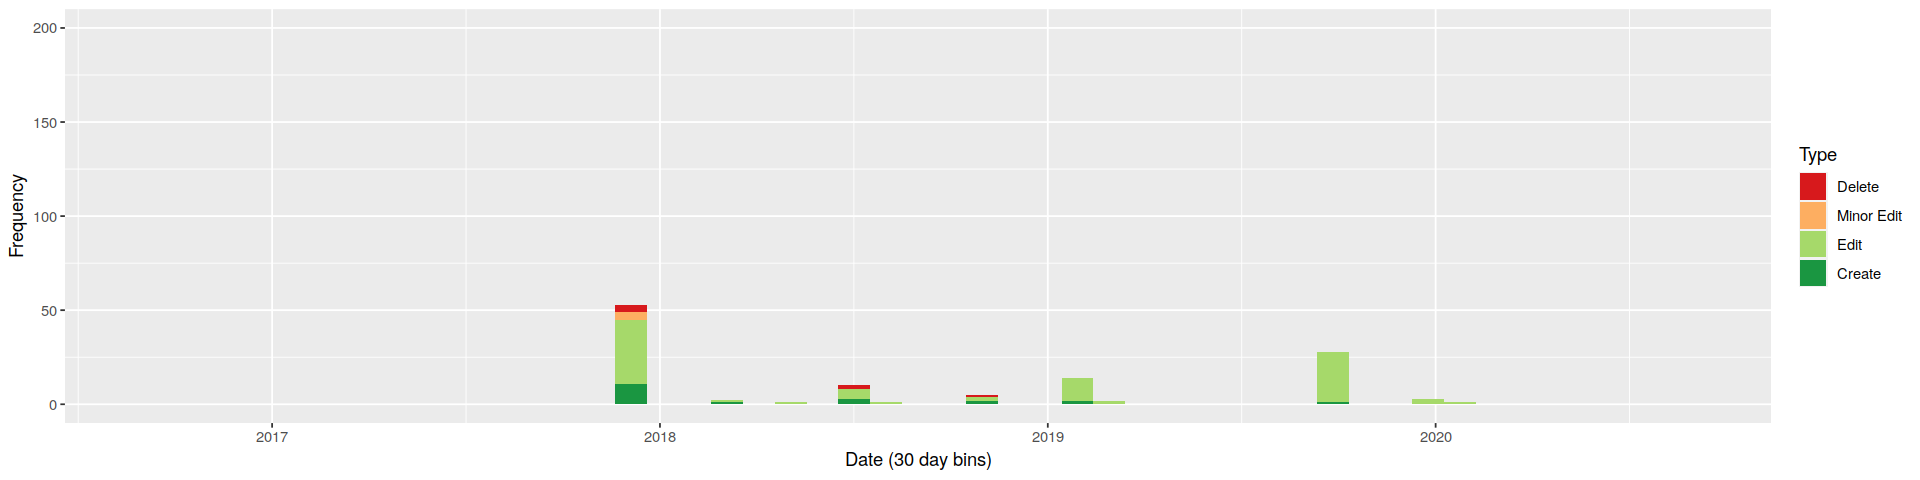

In [85]:
set_size(width=16)

col_changes %>%
    ggplot(aes(x=as.Date(date), fill=type)) +
        geom_histogram(binwidth = 30, boundary = 30) +
        scale_fill_brewer("Type", type = "div", palette = 8) +
        xlim(as.Date("2016-09-01"), as.Date("2020-08-31")) +
        ylim(0, 200) +
        labs(x="Date (30 day bins)", y="Frequency")
ggsave(filename = "output/wiki_changes-phd_collections.pdf",
       width = getOption("repr.plot.width"),
       height = getOption("repr.plot.height"))

## Experiments

### Revision history for phd:experiments namespace

Run the following command in the directory of your DokuWiki instance to generate the required data for analysis (put it in the data directory of the notebook):

```
$ find data/meta/phd/experiments -name "*.changes" | xargs cat > phd_experiments-changes.tsv
```

In [86]:
exp_changes <- load_wiki_changes(file.path(data_dir, "phd_experiments-changes.tsv")); exp_changes

timestamp  date                ip             type  
1    1548688248 2019-01-28 15:10:48 10.227.145.25  Delete
2    1511867703 2017-11-28 11:15:03 172.30.7.198   Create
3    1511868995 2017-11-28 11:36:35 172.30.7.198   Edit  
4    1511869125 2017-11-28 11:38:45 172.30.7.198   Edit  
5    1511869157 2017-11-28 11:39:17 172.30.7.198   Edit  
6    1511869226 2017-11-28 11:40:26 172.30.7.198   Edit  
7    1511869289 2017-11-28 11:41:29 172.30.7.198   Edit  
8    1511869294 2017-11-28 11:41:34 172.30.7.198   Edit  
9    1511869303 2017-11-28 11:41:43 172.30.7.198   Edit  
10   1511869349 2017-11-28 11:42:29 172.30.7.198   Edit  
11   1511875278 2017-11-28 13:21:18 172.30.7.198   Edit  
12   1511875288 2017-11-28 13:21:28 172.30.7.198   Edit  
13   1511875298 2017-11-28 13:21:38 172.30.7.198   Edit  
14   1511877681 2017-11-28 14:01:21 172.30.7.198   Edit  
15   1511880053 2017-11-28 14:40:53 172.30.7.198   Edit  
16   1511881253 2017-11-28 15:00:53 172.30.7.198   Edit  
17   1511881495 2017-11-28 15:04:55 172.30.7.198   Edit  
18   1511881522 2017-11-28 15:05:22 172.30.7.198   Edit  
19   1511881556 2017-11-28 15:05:56 172.30.7.198   Edit  
20   1511881929 2017-11-28 15:12:09 172.30.7.198   Edit  
21   1511882534 2017-11-28 15:22:14 172.30.7.198   Edit  
22   1511882614 2017-11-28 15:23:34 172.30.7.198   Edit  
23   1511882633 2017-11-28 15:23:53 172.30.7.198   Edit  
24   1511882658 2017-11-28 15:24:18 172.30.7.198   Edit  
25   1511882693 2017-11-28 15:24:53 172.30.7.198   Edit  
26   1511882710 2017-11-28 15:25:10 172.30.7.198   Edit  
27   1511882858 2017-11-28 15:27:38 172.30.7.198   Edit  
28   1511882942 2017-11-28 15:29:02 172.30.7.198   Edit  
29   1511882978 2017-11-28 15:29:38 172.30.7.198   Edit  
30   1511883045 2017-11-28 15:30:45 172.30.7.198   Edit  
⋮    ⋮          ⋮                   ⋮              ⋮     
1182 1553606437 2019-03-26 13:20:37 10.227.107.163 Create
1183 1553606914 2019-03-26 13:28:34 10.227.107.163 Edit  
1184 1553606924 2019-03-26 13:28:44 10.227.107.163 Edit  
1185 1553606939 2019-03-26 13:28:59 10.227.107.163 Edit  
1186 1553607003 2019-03-26 13:30:03 10.227.107.163 Edit  
1187 1553607067 2019-03-26 13:31:07 10.227.107.163 Edit  
1188 1553607701 2019-03-26 13:41:41 10.227.107.163 Edit  
1189 1553607763 2019-03-26 13:42:43 10.227.107.163 Edit  
1190 1553608017 2019-03-26 13:46:57 10.227.107.163 Edit  
1191 1553608101 2019-03-26 13:48:21 10.227.107.163 Edit  
1192 1553608113 2019-03-26 13:48:33 10.227.107.163 Edit  
1193 1553608308 2019-03-26 13:51:48 10.227.107.163 Edit  
1194 1553608347 2019-03-26 13:52:27 10.227.107.163 Edit  
1195 1553608362 2019-03-26 13:52:42 10.227.107.163 Edit  
1196 1553608452 2019-03-26 13:54:12 10.227.107.163 Edit  
1197 1553608547 2019-03-26 13:55:47 10.227.107.163 Edit  
1198 1553608579 2019-03-26 13:56:19 10.227.107.163 Edit  
1199 1553608597 2019-03-26 13:56:37 10.227.107.163 Edit  
1200 1553608675 2019-03-26 13:57:55 10.227.107.163 Edit  
1201 1553608776 2019-03-26 13:59:36 10.227.107.163 Edit  
1202 1553608864 2019-03-26 14:01:04 10.227.107.163 Edit  
1203 1553609045 2019-03-26 14:04:05 10.227.107.163 Edit  
1204 1553609067 2019-03-26 14:04:27 10.227.107.163 Edit  
1205 1553609118 2019-03-26 14:05:18 10.227.107.163 Edit  
1206 1553615956 2019-03-26 15:59:16 10.227.145.25  Edit  
1207 1553616391 2019-03-26 16:06:31 10.227.145.25  Edit  
1208 1553616416 2019-03-26 16:06:56 10.227.145.25  Edit  
1209 1569336987 2019-09-24 15:56:27 10.227.151.142 Create
1210 1569336995 2019-09-24 15:56:35 10.227.151.142 Edit  
1211 1537197918 2018-09-17 16:25:18 172.30.7.42    Delete
     id                                  user
1    phd:experiments:random-walk-fatigue jld 
2    phd:experiments:graph-of-entity     jld 
3    phd:experiments:graph-of-entity     jld 
4    phd:experiments:graph-of-entity     jld 
5    phd:experiments:graph-of-entity     jld 
6    phd:experiments:graph-of-entity     jld 
7    phd:experiments:graph-of-entity     jld 
8    phd:experiments:graph-of-entity     

Warning message:
“Removed 10 rows containing missing values (geom_bar).”
Warning message:
“Removed 10 rows containing missing values (geom_bar).”


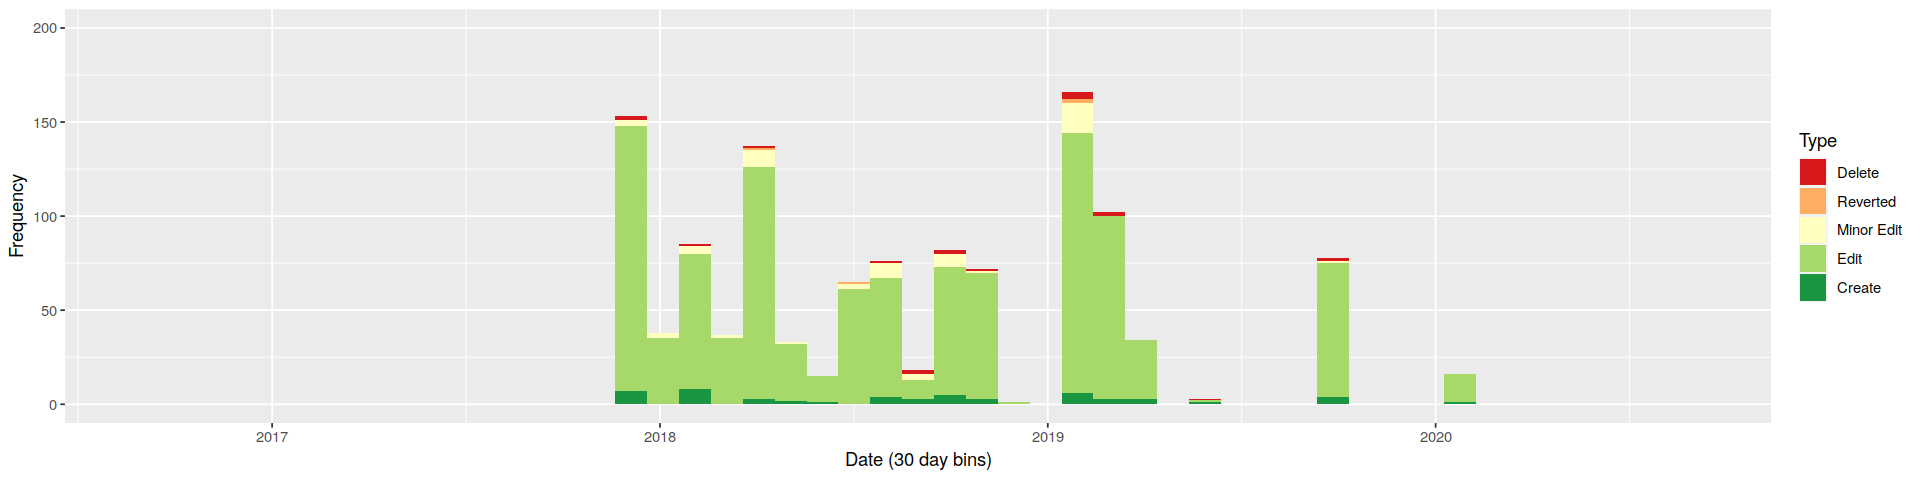

In [88]:
set_size(width=16)

exp_changes %>%
    ggplot(aes(x=as.Date(date), fill=type)) +
        geom_histogram(binwidth = 30, boundary = 30) +
        scale_fill_brewer("Type", type = "div", palette = 8) +
        xlim(as.Date("2016-09-01"), as.Date("2020-08-31")) +
        ylim(0, 200) +
        labs(x="Date (30 day bins)", y="Frequency")
ggsave(filename = "output/wiki_changes-phd_experiments.pdf",
       width = getOption("repr.plot.width"),
       height = getOption("repr.plot.height"))